## Problem Description 
**This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.**

**The names and usernames have been given codes to avoid any privacy concerns.**

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\Dell\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Loading Dataset

In [2]:
df = pd.read_csv('C:/Users/Dell/Desktop/CASE STUDY/Coronavirus Tweets/Copy of Coronavirus Tweets.csv')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [3]:
df.shape

(41157, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [7]:
df['Location'].value_counts()
#df['Location'].nunique() = 12220

London                            540
United States                     528
London, England                   520
New York, NY                      395
Washington, DC                    373
                                 ... 
Living under a bridge in CA         1
Kingdom of Wakanda                  1
In the countryside... always.       1
Watford, South Oxhey, Bushey        1
University of Waterloo, Canada      1
Name: Location, Length: 12220, dtype: int64

In [145]:
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

**All tweets came only from March and April month of 2020.**

In [146]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

**There are 5 unique sentiment types in our dataset**
## Null Values
**Heat Map for missing values**

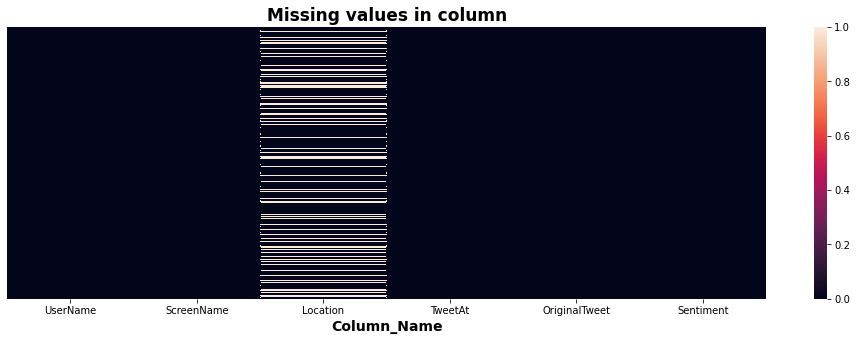

In [10]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Missing values in column",fontweight="bold",size=17)
plt.show()

**missing values in Location Column**

In [19]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]
missing_values

,column,percent
2,Location,20.87


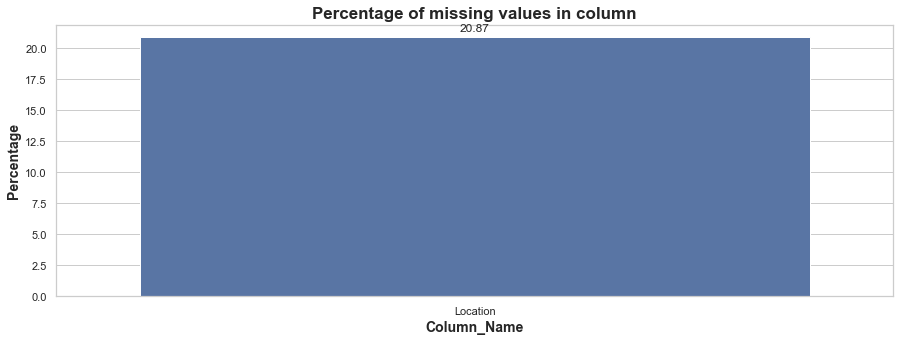

In [21]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)

#for displaying percentage
for p in splot.patches:     
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

**Only Location column contains 28% null values. But this column is not useful for our sentiment analysis.Hence we will neglect these null values.**
## Unique Values In Each Feature Coulmn

In [150]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]

for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

unique_df

,Features,Uniques
0,UserName,41157
1,ScreenName,41157
2,Location,12220
3,TweetAt,30
4,OriginalTweet,41157
5,Sentiment,5


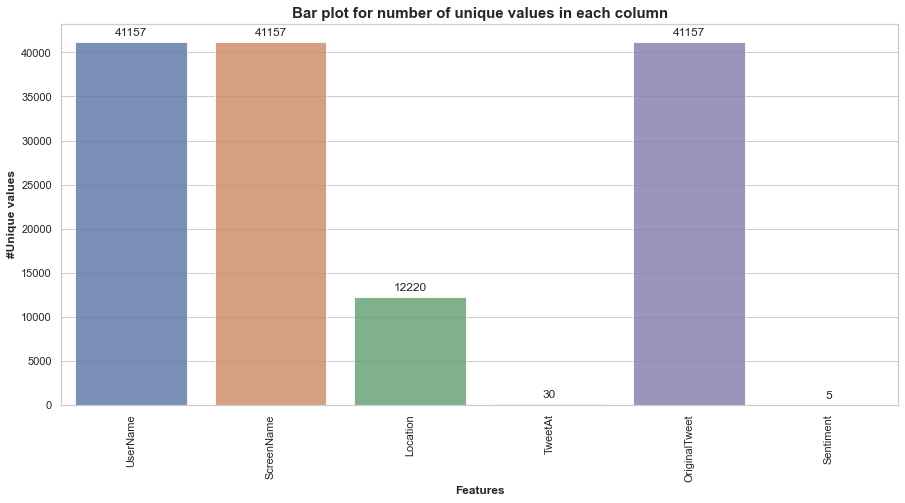

In [151]:
f, ax = plt.subplots(1,1, figsize=(15,7))
splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)

#for displaying unique count
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

### Top 10 locations of tweet

In [24]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)
Top_Location_Of_tweet

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [28]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London, England'),
 Text(3, 0, 'New York, NY'),
 Text(4, 0, 'Washington, DC'),
 Text(5, 0, 'United Kingdom'),
 Text(6, 0, 'Los Angeles, CA'),
 Text(7, 0, 'India'),
 Text(8, 0, 'UK'),
 Text(9, 0, 'Australia')]

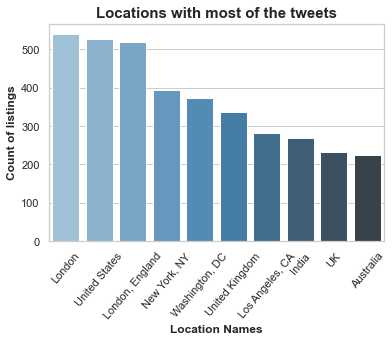

In [40]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='Blues_d')

viz_1.set_title('Locations with most of the tweets', size=15, weight='bold')
viz_1.set_ylabel('Count of listings', size=12, weight='bold')
viz_1.set_xlabel('Location Names', size=12, weight='bold')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=50)

### Sentiments Countplot

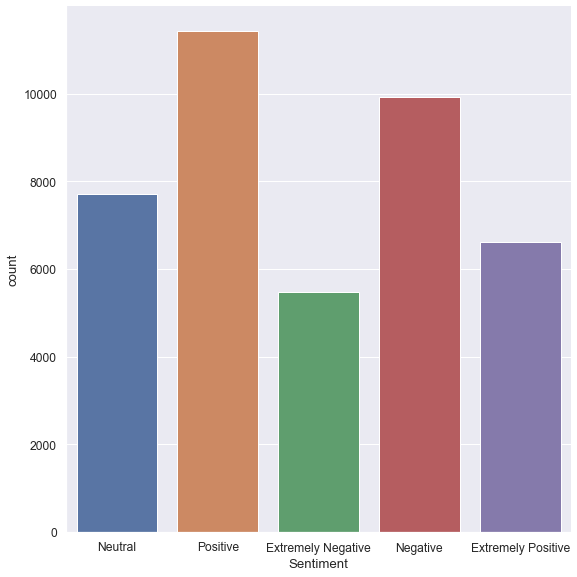

In [155]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

## Data Preprocessing
###### Removing @user

In [41]:
def remove_pattern(txt, pattern):
    r = re.findall(pattern, txt)
    for word in r:
        txt = re.sub(word,'',txt)
    return txt

In [42]:
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."


###### Removing URLS from tweet

In [43]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."


###### Removing Punctuations, Numbers, and Special Characters

In [44]:
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,My food stock is not the only one which is empty PLEASE don t panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe #COVID france #COVID #COVID #co...


######  Removing Short Words

In [45]:
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...


###### Tokenization

In [46]:
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
tokenized_tweet

0                                                                                                                                                                                                             []
1        [advice, Talk, your, neighbours, family, exchange, phone, numbers, create, contact, list, with, phone, numbers, neighbours, schools, employer, chemist, set, online, shopping, accounts, poss, adequ...
2                                                                                               [Coronavirus, Australia, Woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, COVID, outbreak]
3        [food, stock, not, the, only, one, which, empty, PLEASE, don, panic, THERE, WILL, ENOUGH, FOOD, FOR, EVERYONE, you, not, take, more, than, you, need, Stay, calm, stay, safe, #COVID, france, #COVID...
4        [ready, supermarket, during, the, #COVID, outbreak, Not, because, paranoid, but, because, food, stock, litteraly, empty, The, #coronavirus, serious, thing,

In [47]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


###### stemming

In [48]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet

0                                                                                                                                                                                                             []
1        [advic, talk, your, neighbour, famili, exchang, phone, number, creat, contact, list, with, phone, number, neighbour, school, employ, chemist, set, onlin, shop, account, poss, adequ, suppli, regula...
2                                                                                                            [coronaviru, australia, woolworth, give, elderli, disabl, dedic, shop, hour, amid, covid, outbreak]
3        [food, stock, not, the, onli, one, which, empti, pleas, don, panic, there, will, enough, food, for, everyon, you, not, take, more, than, you, need, stay, calm, stay, safe, #covid, franc, #covid, #...
4        [readi, supermarket, dure, the, #covid, outbreak, not, becaus, paranoid, but, becaus, food, stock, litterali, empti, the, #coronaviru, seriou, thing, but, 

In [49]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


In [50]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

tokenized_tweet

0                                                                                                                                                                                                               
1             advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2                                                                                                                         coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3        food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4        readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus 

In [51]:
# change df['Tweet'] to tokenized_tweet
df['Tweet']  = tokenized_tweet
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order


## Story Generation and Visualization from Tweets
- What are the most common words in the entire dataset?

- What are the most common words in the dataset for negative and positive tweets, respectively?

- How many hashtags are there in a tweet?

- Which trends are associated with my dataset?

- Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

###### common words used in the tweets

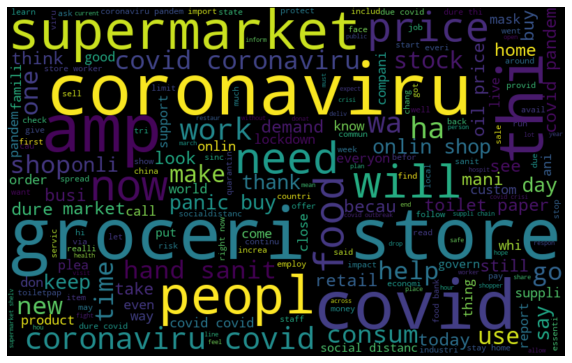

In [80]:
all_words = ' '.join([sentence for sentence in df['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###### common words in the dataset for Extremely Positive Sentiment

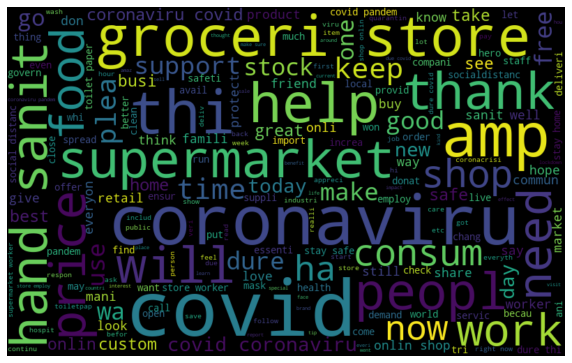

In [81]:
normal_words = ' '.join([sentence for sentence in df['Tweet'][df['Sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###### common words in the dataset for Extremely Negative Sentiment

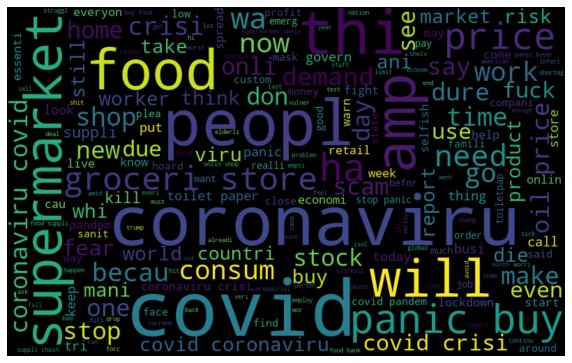

In [83]:
normal_words = ' '.join([sentence for sentence in df['Tweet'][df['Sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###### common words in the dataset for Positive Sentiment

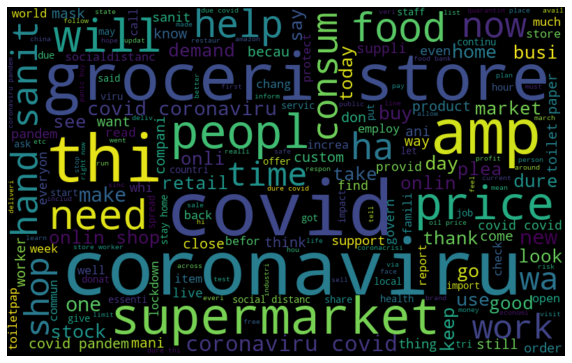

In [85]:
normal_words = ' '.join([sentence for sentence in df['Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###### common words in the dataset for Negative Sentiment

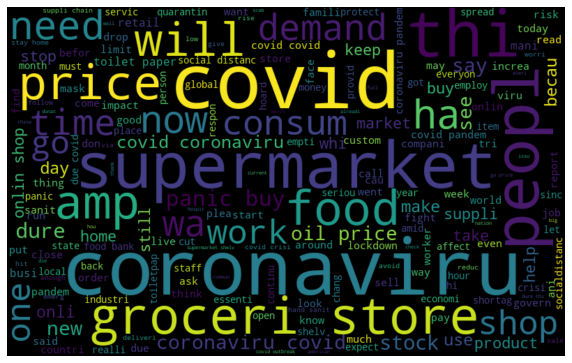

In [86]:
normal_words = ' '.join([sentence for sentence in df['Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###### common words in the dataset for Neutral Sentiment

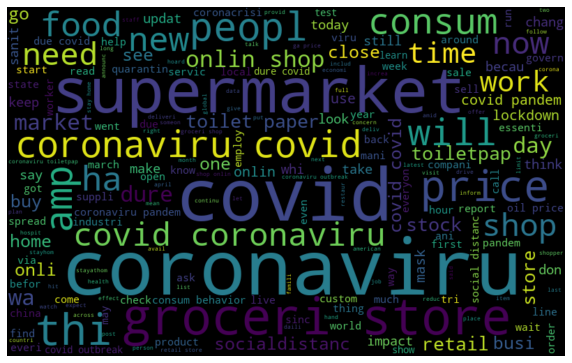

In [87]:
normal_words = ' '.join([sentence for sentence in df['Tweet'][df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Understanding the impact of Hashtags on tweets sentiment
**hashtag helps in understanding what that tweet is about**

In [52]:
# extract the hashtags

def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [53]:
#extracting hashtags where Sentiment is Extremely Positive
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])

#extracting hashtags where Sentiment is Extremely Negative
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])

#extracting hashtags where Sentiment is Positive
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])

#extracting hashtags where Sentiment is Negative
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])

#extracting hashtags where Sentiment is neutral
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])

In [54]:
HT_Extremely_Positive

[[],
 ['horningsea'],
 [],
 ['COVID2019',
  'Trials',
  'Monthly',
  'Yearly',
  'Prices',
  'Subscriptions',
  'bestiptv',
  'iptv',
  'Service',
  'Iptv',
  'iptvdeals',
  'Cheap',
  'ipTV',
  'Football',
  'HD',
  'Movies',
  'Adult',
  'Cinema',
  'hotmovies',
  'iptvnew',
  'iptv2020',
  'Adult'],
 ['COVID2019',
  'Trials',
  'Monthly',
  'Yearly',
  'Prices',
  'Subscriptions',
  'bestiptv',
  'iptv',
  'Service',
  'Iptv',
  'iptvdeals',
  'Cheap',
  'ipTV',
  'Football',
  'HD',
  'Movies',
  'Adult',
  'Cinema',
  'hotmovies',
  'ipTv',
  '18Movies'],
 ['consumer', 'covid19', 'tracker'],
 ['BreakingNews',
  'Breaking',
  'Coronavirus',
  'CoronavirusOutbreak',
  'COVID19',
  'COVID',
  'COVID_19',
  'COVID2019',
  'Collapse'],
 ['CoronavirusOutbreak', 'coronavirus', 'COVID2019'],
 ['jlmco',
  'jlmcobrand',
  'coronapocolypse',
  'coronavirus',
  'CoronavirusOutbreak',
  'COVID19',
  'shoponline'],
 [],
 ['coronavirus',
  'COVID19',
  'peoplearelosingtheirminds',
  'StopTheMadn

In [55]:
HT_Extremely_Negative

[['COVID19',
  'coronavirus',
  'CoronavirusFrance',
  'restezchezvous',
  'StayAtHome',
  'confinement'],
 [],
 [],
 ['Coronavirus', 'StockUp'],
 ['CoronavirusOutbreak',
  'coronavirus',
  'houston',
  'nofood',
  'Notoiletpaper',
  'NoHandShakes',
  'nohandsanitizer',
  'COVID19',
  'pandemic',
  'totallockdown',
  'COVID2019usa',
  'walmart'],
 [],
 [],
 ['coronavirus'],
 [],
 ['CoronavirusOutbreak'],
 [],
 [],
 [],
 ['COVID',
  'coronavirus',
  'coronavirusuk',
  'anxiety',
  'panicbuyinguk',
  'morons'],
 [],
 [],
 [],
 ['COVID2019'],
 ['coronavirus', 'retail', 'Covid19Walkout'],
 ['Coronavirus'],
 [],
 [],
 [],
 ['Thread'],
 [],
 [],
 ['coronavirus'],
 ['covid',
  'Coronavirus',
  'coronavirus',
  'Coronavirusupdate',
  'Coronapocolypse'],
 ['cct320'],
 [],
 [],
 ['toiletpaper', 'coronavirus'],
 ['coronavirus', 'coronapocolypse'],
 ['French', 'coronavirus'],
 [],
 ['coronavirus'],
 ['coronavirus', 'StayInformed', 'StayConnected', 'NAILBA2020'],
 [],
 ['COVID2019'],
 ['bread', 'co

In [56]:
HT_Positive

[[],
 [],
 ['COVID19france',
  'COVID_19',
  'COVID19',
  'coronavirus',
  'confinement',
  'Confinementotal',
  'ConfinementGeneral'],
 [],
 ['Covid_19'],
 [],
 ['CoronaVirus'],
 [],
 ['coronavirus', 'covid19'],
 [],
 [],
 ['COVID19'],
 ['CoronavirusOutbreak', 'COVID2019'],
 ['economy', 'onlineshopping', 'coronavirus', 'covid19', 'stayhome'],
 ['coronavirus', 'COVID19'],
 ['coronapocolypse', 'coronavirus'],
 ['coronavirus'],
 ['LockdownCanada', 'coronavirus'],
 [],
 ['Coronavirus', 'COVID19'],
 [],
 [],
 ['covid19', 'ecommerce', 'omnichannel', 'retail', 'digital'],
 [],
 ['coronavirus'],
 ['coronavirus'],
 [],
 [],
 [],
 ['COVID2019', 'StayHealthy'],
 ['coronavirus'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Covid_19',
  'pricegougers',
  'Hoarders',
  'Idiots',
  'panicbuying',
  'selfishpeople'],
 [],
 [],
 ['CoronavirusOutbreak'],
 ['coronavirus'],
 [],
 [],
 [],
 [],
 ['COVID',
  'COVID19',
  'coronapocolypse',
  'coronavirus',
  'COVID',
  'Hoarders',
  'groceries',
  'panicshopping',
  

In [57]:
HT_Negative

[['govindia', 'IndiaFightsCorona'],
 [],
 [],
 ['COVID19', 'CovidNYC'],
 [],
 [],
 [],
 ['CoronaVirusSA', 'Covid_19'],
 ['coronavirus'],
 ['Scammers', 'COVID', 'coronavirus', 'cdc', 'flu', 'trends', 'alert'],
 ['nameandshame', 'covid', 'coronavirus', 'Liverpool'],
 [],
 ['services', 'food', 'delivery', 'coronavirus'],
 ['COVID', 'COVID19Aus', 'coronavirus'],
 [],
 ['DontPanicBuy', 'coronavirus'],
 [],
 [],
 ['coronapocolypse', 'Covid_19', 'panicbuying'],
 ['coronavirus', 'panicbuying', 'whatashitshow'],
 ['stoppanickbuying', 'thinkingofothers', 'coronavirus', 'COVID19'],
 ['Covid_19', 'panicshopping', 'pricegougers', 'Idiots'],
 [],
 [],
 ['unpopularopinion', 'COVID2019', 'Malaysia2020'],
 [],
 ['coronavirus', 'pricegouging'],
 ['coronavirus'],
 ['KenyanTraffic', 'coronavirus'],
 ['scrubs', 'covid19', 'Medtwitter', 'coronavirus'],
 ['Kashmir',
  'CoronavirusOutbreak',
  'KashmirLockdown',
  'Kashmiris',
  'COVID2019',
  'coronapocolypse'],
 ['coronavirus', 'covid19', 'nationalquarantin

In [58]:
HT_Neutral

[[],
 ['Rebel', 'toiletpapercrisis', 'covid_19'],
 ['manila', 'lockdown', 'covid2019', 'Philippines'],
 [],
 [],
 [],
 ['coronavirus', 'BrickAndMortar'],
 ['COVID2019'],
 ['QuarantineLife',
  'CoronavirusOutbreak',
  'coronavirus',
  'IMadeThisUp',
  'FakeNews'],
 [],
 [],
 ['covid_19', 'pandemic', 'socialdistancing', 'retail'],
 [],
 [],
 [],
 [],
 ['seafood',
  'coronavirus',
  'CoronavirusOutbreak',
  'CoronavirusReachesDelhi',
  'Coronavid19',
  'CoronaVirusUpdates',
  'COVID2019',
  'COVID19',
  'JhalakBollywood',
  'JhalakKollywood',
  'JhalakTollywood'],
 [],
 [],
 [],
 ['coronavirus'],
 ['TrumpIsAnIdiot', 'trumpneedstoshutup', 'coronavirus'],
 [],
 ['Priorities', 'CoronaVirus'],
 ['COVID2019'],
 [],
 [],
 ['retail', 'retailapocalypse2020', 'coronavirus', 'retailnews'],
 ['COVID19', 'Coronavirus', 'LOTL'],
 [],
 [],
 [],
 ['boomers', 'COVID2019', 'SocialDista'],
 ['Dallas', 'coronapocolypse', 'COVID2019'],
 ['CoronaVirusUpdates', 'CoronaVirus'],
 ['immunesystem', 'immunesupport'

In [59]:
# unnesting list - combining all hashtags in sentance to a single list

HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

In [60]:
print(HT_Extremely_Positive)

['horningsea', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'iptvnew', 'iptv2020', 'Adult', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'ipTv', '18Movies', 'consumer', 'covid19', 'tracker', 'BreakingNews', 'Breaking', 'Coronavirus', 'CoronavirusOutbreak', 'COVID19', 'COVID', 'COVID_19', 'COVID2019', 'Collapse', 'CoronavirusOutbreak', 'coronavirus', 'COVID2019', 'jlmco', 'jlmcobrand', 'coronapocolypse', 'coronavirus', 'CoronavirusOutbreak', 'COVID19', 'shoponline', 'coronavirus', 'COVID19', 'peoplearelosingtheirminds', 'StopTheMadness', 'stoppanicbuying', 'coronavirus', 'StopPanicBuying', 'BeKind', 'mufc', 'MUFC_Family', 'Malaysia2020', 'Malaysia', 'COVID', 'COVID2019', 'Quarantine

In [61]:
print(HT_Extremely_Negative)

['COVID19', 'coronavirus', 'CoronavirusFrance', 'restezchezvous', 'StayAtHome', 'confinement', 'Coronavirus', 'StockUp', 'CoronavirusOutbreak', 'coronavirus', 'houston', 'nofood', 'Notoiletpaper', 'NoHandShakes', 'nohandsanitizer', 'COVID19', 'pandemic', 'totallockdown', 'COVID2019usa', 'walmart', 'coronavirus', 'CoronavirusOutbreak', 'COVID', 'coronavirus', 'coronavirusuk', 'anxiety', 'panicbuyinguk', 'morons', 'COVID2019', 'coronavirus', 'retail', 'Covid19Walkout', 'Coronavirus', 'Thread', 'coronavirus', 'covid', 'Coronavirus', 'coronavirus', 'Coronavirusupdate', 'Coronapocolypse', 'cct320', 'toiletpaper', 'coronavirus', 'coronavirus', 'coronapocolypse', 'French', 'coronavirus', 'coronavirus', 'coronavirus', 'StayInformed', 'StayConnected', 'NAILBA2020', 'COVID2019', 'bread', 'coronavirus', 'covid', 'stockup', 'davesbread', 'coronavirus', 'coronavirus', 'Yorkshire', 'UK', 'Iran', 'coronavirus', 'Italy', 'COVID2019', 'India', 'Bharat', 'coronavirus', 'COVID19', 'AfricanHistoryClass', 

In [62]:
print(HT_Positive)

['COVID19france', 'COVID_19', 'COVID19', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral', 'Covid_19', 'CoronaVirus', 'coronavirus', 'covid19', 'COVID19', 'CoronavirusOutbreak', 'COVID2019', 'economy', 'onlineshopping', 'coronavirus', 'covid19', 'stayhome', 'coronavirus', 'COVID19', 'coronapocolypse', 'coronavirus', 'coronavirus', 'LockdownCanada', 'coronavirus', 'Coronavirus', 'COVID19', 'covid19', 'ecommerce', 'omnichannel', 'retail', 'digital', 'coronavirus', 'coronavirus', 'COVID2019', 'StayHealthy', 'coronavirus', 'Covid_19', 'pricegougers', 'Hoarders', 'Idiots', 'panicbuying', 'selfishpeople', 'CoronavirusOutbreak', 'coronavirus', 'COVID', 'COVID19', 'coronapocolypse', 'coronavirus', 'COVID', 'Hoarders', 'groceries', 'panicshopping', 'StopPanicBuying', 'coronavirus', 'COVID2019', 'StaySafe', 'frontlines', 'WINWIN', 'coronavirus', 'stayindoorsandshop', 'coronavirus', 'StopPanicBuying', 'reverselogistics', 'COVID', 'ECommerce', 'Returns', 'Coronavirus', 'panicb

In [63]:
print(HT_Negative)

['govindia', 'IndiaFightsCorona', 'COVID19', 'CovidNYC', 'CoronaVirusSA', 'Covid_19', 'coronavirus', 'Scammers', 'COVID', 'coronavirus', 'cdc', 'flu', 'trends', 'alert', 'nameandshame', 'covid', 'coronavirus', 'Liverpool', 'services', 'food', 'delivery', 'coronavirus', 'COVID', 'COVID19Aus', 'coronavirus', 'DontPanicBuy', 'coronavirus', 'coronapocolypse', 'Covid_19', 'panicbuying', 'coronavirus', 'panicbuying', 'whatashitshow', 'stoppanickbuying', 'thinkingofothers', 'coronavirus', 'COVID19', 'Covid_19', 'panicshopping', 'pricegougers', 'Idiots', 'unpopularopinion', 'COVID2019', 'Malaysia2020', 'coronavirus', 'pricegouging', 'coronavirus', 'KenyanTraffic', 'coronavirus', 'scrubs', 'covid19', 'Medtwitter', 'coronavirus', 'Kashmir', 'CoronavirusOutbreak', 'KashmirLockdown', 'Kashmiris', 'COVID2019', 'coronapocolypse', 'coronavirus', 'covid19', 'nationalquarantine', 'coronavirus', 'covid19', 'coronavirus', 'COVID', 'coronavirus', 'covid', 'coronavirus', 'panicshopping', 'coronavirus', 'CO

In [64]:
print(HT_Neutral)

['Rebel', 'toiletpapercrisis', 'covid_19', 'manila', 'lockdown', 'covid2019', 'Philippines', 'coronavirus', 'BrickAndMortar', 'COVID2019', 'QuarantineLife', 'CoronavirusOutbreak', 'coronavirus', 'IMadeThisUp', 'FakeNews', 'covid_19', 'pandemic', 'socialdistancing', 'retail', 'seafood', 'coronavirus', 'CoronavirusOutbreak', 'CoronavirusReachesDelhi', 'Coronavid19', 'CoronaVirusUpdates', 'COVID2019', 'COVID19', 'JhalakBollywood', 'JhalakKollywood', 'JhalakTollywood', 'coronavirus', 'TrumpIsAnIdiot', 'trumpneedstoshutup', 'coronavirus', 'Priorities', 'CoronaVirus', 'COVID2019', 'retail', 'retailapocalypse2020', 'coronavirus', 'retailnews', 'COVID19', 'Coronavirus', 'LOTL', 'boomers', 'COVID2019', 'SocialDista', 'Dallas', 'coronapocolypse', 'COVID2019', 'CoronaVirusUpdates', 'CoronaVirus', 'immunesystem', 'immunesupport', 'coronavirus', 'covid_19', 'Food', 'coronavirus', 'foodshortage', 'foodsecurity', 'Stockpile', 'Canada', 'Meat', 'hoarding', 'coronavirus', 'nomestleft', 'nofood', 'canad

In [65]:
# making frequency distribution top 10 Extremely Positive hashtags

a = nltk.FreqDist(HT_Extremely_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})
d.head()

,Hashtag,Count
0,horningsea,1
1,COVID2019,248
2,Trials,3
3,Monthly,3
4,Yearly,3


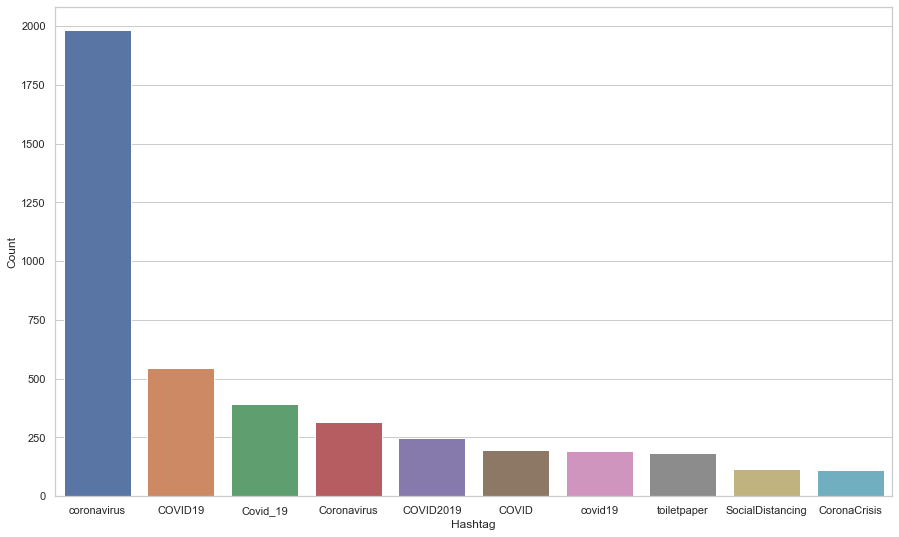

In [68]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [130]:
# making frequency distribution top 10 Extremely Negative hashtags

a = nltk.FreqDist(HT_Extremely_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})
d.head()

,Hashtag,Count
0,COVID19,381
1,coronavirus,1655
2,CoronavirusFrance,1
3,restezchezvous,1
4,StayAtHome,29


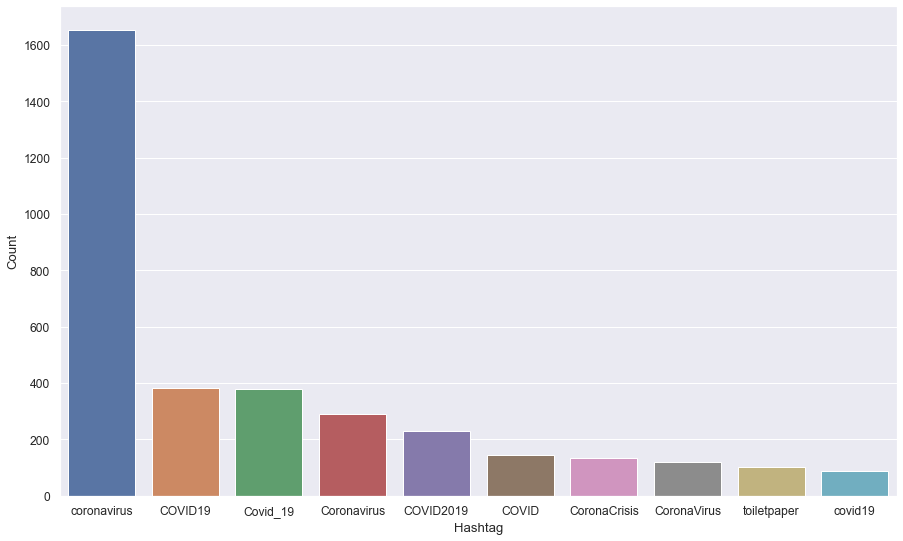

In [131]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [132]:
# making frequency distribution top 10 Positive hashtags

a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})
d.head()

,Hashtag,Count
0,COVID19france,1
1,COVID_19,45
2,COVID19,976
3,coronavirus,3581
4,confinement,3


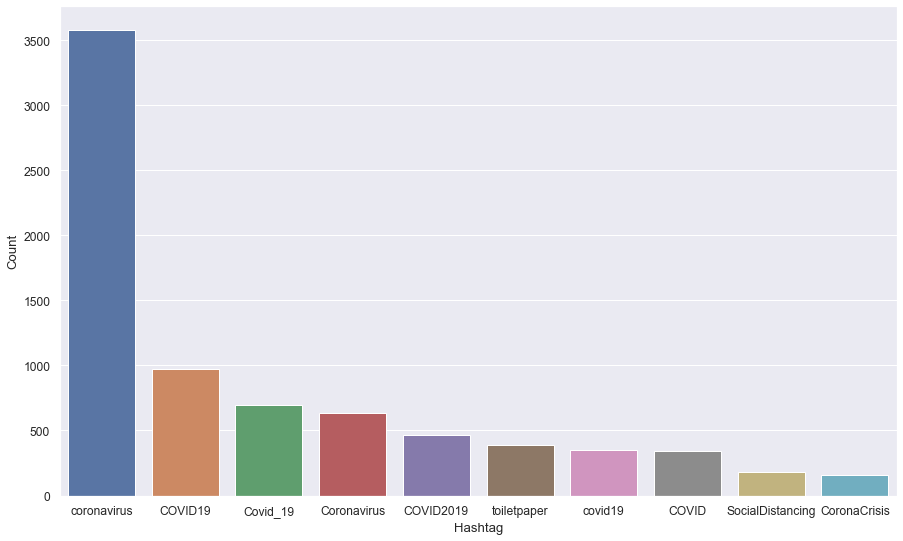

In [133]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [134]:
# making frequency distribution top 10 Negative hashtags

a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})
d.head()

,Hashtag,Count
0,govindia,1
1,IndiaFightsCorona,7
2,COVID19,725
3,CovidNYC,1
4,CoronaVirusSA,3


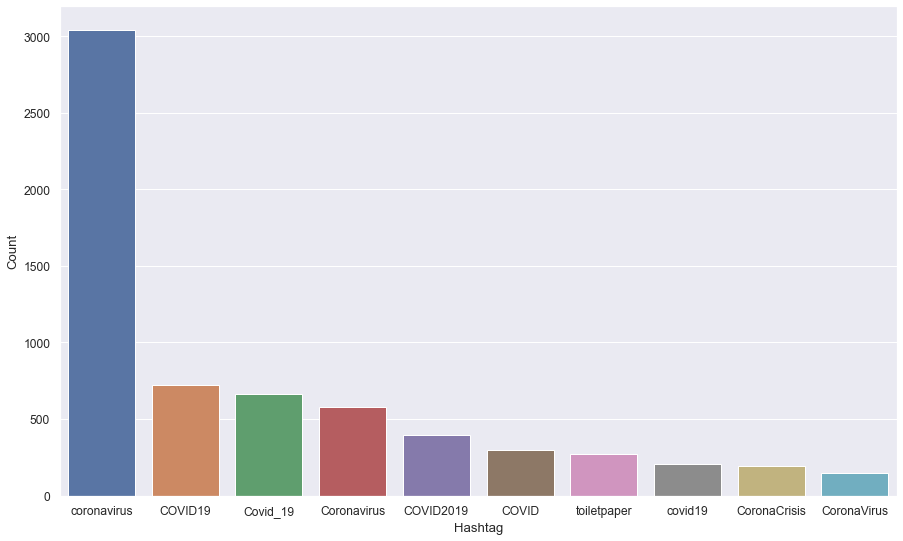

In [135]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [136]:
# making frequency distribution top 10 Neutral hashtags

a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})
d.head()

,Hashtag,Count
0,Rebel,1
1,toiletpapercrisis,55
2,covid_19,153
3,manila,1
4,lockdown,86


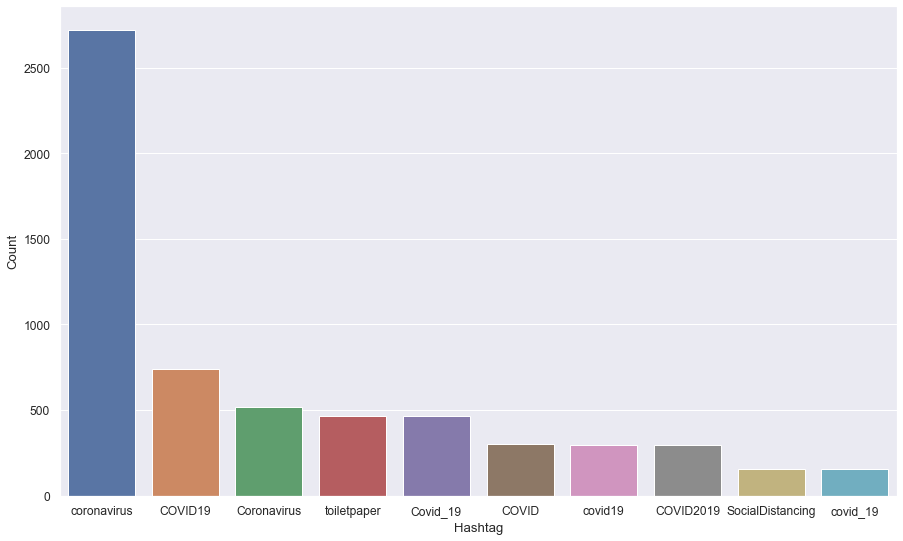

In [137]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

## Best Model Selection
######  Extracting Features from Cleaned Tweets

In [69]:
new_df = df[['Tweet','Sentiment']]
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [169]:
new_df.shape

(41157, 2)

In [170]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

###### Removing Stopwords

In [70]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
new_df['Tweet'].apply(lambda sentence: [word for word in sentence if word not in stop])
new_df['Tweet']

0                                                                                                                                                                                                               
1             advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2                                                                                                                         coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3        food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4        readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus 

In [72]:
new_df.head(6)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative
5,news the region first confirm covid case came out sullivan counti last week peopl flock area store purchas clean suppli hand sanit food toilet paper and other good report,Positive


###### Spitting  Dataset into Training And Testing Dataset For Multiclass Classification

In [82]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (32925, 2)
test shape :  (8232, 2)


###### CountVectorizer For Multiclass Classification

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (32925, 27089)
X_test.shape :  (8232, 27089)
y_train.shape :  (32925,)
y_test.shape :  (8232,)


#### Naive Bayes Classifier for MULTICLASS Classification

In [180]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)

print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Testing accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

training accuracy Score    :  0.6931511009870919
Testing accuracy Score :  0.47947035957240036
                    precision    recall  f1-score   support

Extremely Negative       0.39      0.59      0.47       736
Extremely Positive       0.40      0.58      0.47       907
          Negative       0.52      0.43      0.47      2398
           Neutral       0.34      0.67      0.45       786
          Positive       0.62      0.42      0.50      3405

          accuracy                           0.48      8232
         macro avg       0.46      0.54      0.47      8232
      weighted avg       0.52      0.48      0.48      8232



#### SGD Classifier for MULTICLASS Classification

In [181]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.8288838268792711
Testing accuracy Score :  0.5726433430515063
                    precision    recall  f1-score   support

Extremely Negative       0.68      0.62      0.65      1210
Extremely Positive       0.68      0.65      0.67      1396
          Negative       0.45      0.50      0.48      1785
           Neutral       0.75      0.59      0.66      1963
          Positive       0.44      0.54      0.48      1878

          accuracy                           0.57      8232
         macro avg       0.60      0.58      0.59      8232
      weighted avg       0.59      0.57      0.58      8232



#### RANDOM FOREST CLASSIFIER for MULTICLASS Classification

In [182]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_test))

Training accuracy Score    :  0.9958997722095672
Testing accuracy Score :  0.5604956268221575
                    precision    recall  f1-score   support

Extremely Negative       0.39      0.69      0.50       621
Extremely Positive       0.36      0.70      0.47       671
          Negative       0.54      0.52      0.53      2064
           Neutral       0.77      0.61      0.68      1941
          Positive       0.64      0.50      0.56      2935

          accuracy                           0.56      8232
         macro avg       0.54      0.60      0.55      8232
      weighted avg       0.60      0.56      0.57      8232



#### Extreme Gradient Boosting(xgb) for MULTICLASS Classification

In [183]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Testing accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_test))

[19:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score    :  0.70958238420653
Testing accuracy Score :  0.592201166180758
                    precision    recall  f1-score   support

Extremely Negative       0.51      0.66      0.57       853
Extremely Positive       0.54      0.72      0.62       993
          Negative       0.49      0.57      0.53      1685
           Neutral       0.80      0.57      0.66      2171
          Positive       0.61      0.55      0.58      2530

          accuracy                           0.59      8232
         macro avg       0.59      0.61      0.59      8232
      weighted avg       0.62      0.59      0.60      8232



#### Support Vector Machine(svm) for MULTICLASS Classification

In [184]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))

Training accuracy Score    :  0.8993773728170084
Testing accuracy Score :  0.6072643343051506
                    precision    recall  f1-score   support

Extremely Negative       0.48      0.71      0.57       738
Extremely Positive       0.53      0.78      0.63       902
          Negative       0.58      0.55      0.56      2082
           Neutral       0.71      0.64      0.67      1718
          Positive       0.67      0.55      0.61      2792

          accuracy                           0.61      8232
         macro avg       0.59      0.65      0.61      8232
      weighted avg       0.62      0.61      0.61      8232



#### Logistic Regression for MULTICLASS Classification

In [189]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.8860744115413819
Testing accuracy Score :  0.6179543245869776
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.68      0.65       999
Extremely Positive       0.62      0.71      0.66      1147
          Negative       0.54      0.56      0.55      1896
           Neutral       0.72      0.64      0.68      1744
          Positive       0.62      0.58      0.59      2446

          accuracy                           0.62      8232
         macro avg       0.62      0.63      0.63      8232
      weighted avg       0.62      0.62      0.62      8232



#### CATBOOST MODEL For MULTICLASS Classification

In [190]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [191]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [192]:
catboost_prediction = clf2.predict(X_test)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Testing accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.6703720577069097
Testing accuracy Score :  0.6203838678328474
                    precision    recall  f1-score   support

Extremely Negative       0.54      0.70      0.61       843
Extremely Positive       0.56      0.76      0.65       974
          Negative       0.53      0.58      0.56      1813
           Neutral       0.81      0.60      0.69      2058
          Positive       0.64      0.58      0.61      2544

          accuracy                           0.62      8232
         macro avg       0.62      0.65      0.62      8232
      weighted avg       0.64      0.62      0.62      8232



#### Test accuracy comparison of MULTICLASS Classification Models

In [193]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
6,CatBoost,0.620384
1,Logistic Regression,0.617954
0,Support Vector Machines,0.607264
5,XGBoost,0.592201
4,Stochastic Gradient Decent,0.572643
2,Random Forest,0.560496
3,Naive Bayes,0.479470


## CONVERTING MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [73]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [74]:
new_df["Sentiment"]= new_df["Sentiment"].replace('Positive',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Positive',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Neutral',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Negative',0) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Negative',0)

In [75]:
new_df.head()

,Tweet,Sentiment
0,,1
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,1
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,1
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,1
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,0


In [76]:
new_df['Sentiment'].value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

In [78]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])
new_df['Tweet']

0                                                                                                                                                                                                               
1             advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2                                                                                                                         coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3        food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4        readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus 

In [201]:
new_df.head(2)

,Tweet,Sentiment
0,,1
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,1


## Best Model Selection
###### Spitting Dataset into Training And Testing Dataset For Binary Class Classification

In [80]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (32925, 2)
test shape :  (8232, 2)


######  CountVectorizer For Binary Class Classification

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (32925, 27205)
X_test.shape :  (8232, 27205)
y_train.shape :  (32925,)
y_test.shape :  (8232,)


#### Naive Bayes Classifier for BINARY CLASS Classification

In [206]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)

print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Testing accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

training accuracy Score    :  0.8585573272589218
Testing accuracy Score :  0.7916666666666666
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      2899
           1       0.85      0.82      0.84      5333

    accuracy                           0.79      8232
   macro avg       0.77      0.78      0.77      8232
weighted avg       0.80      0.79      0.79      8232



#### SGD Classifier for BINARY CLASS Classification

In [207]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.9350949126803341
Testing accuracy Score :  0.8624878522837707
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2882
           1       0.91      0.88      0.89      5350

    accuracy                           0.86      8232
   macro avg       0.85      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



#### RANDOM FOREST CLASSIFIER for BINARY CLASS Classification

In [208]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_test))

Training accuracy Score    :  0.9985725132877753
Testing accuracy Score :  0.8294460641399417
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      2626
           1       0.91      0.83      0.87      5606

    accuracy                           0.83      8232
   macro avg       0.80      0.83      0.81      8232
weighted avg       0.84      0.83      0.83      8232



#### LOGISTIC REGRESSION for BINARY CLASS Classification

In [209]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.937798025816249
Testing accuracy Score :  0.8594509232264335
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2791
           1       0.92      0.87      0.89      5441

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.86      0.86      0.86      8232



#### CATBOOST ALGORITHM for BINARY CLASS Classification

In [210]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [211]:
catboost_prediction = clf2.predict(X_test)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Testing accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.8840091116173121
Testing accuracy Score :  0.8521622934888241
              precision    recall  f1-score   support

           0       0.72      0.86      0.79      2593
           1       0.93      0.85      0.89      5639

    accuracy                           0.85      8232
   macro avg       0.83      0.85      0.84      8232
weighted avg       0.86      0.85      0.86      8232



#### XG BOOST for BINARY CLASS Classification

In [212]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Testing accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_test))

[20:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score    :  0.8509946848899013
Testing accuracy Score :  0.8219144800777454
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      2360
           1       0.93      0.81      0.87      5872

    accuracy                           0.82      8232
   macro avg       0.79      0.83      0.80      8232
weighted avg       0.85      0.82      0.83      8232



#### SUPPORT VECTOR MACHINE(svm) for BINARY CLASS Classification

In [213]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))

Training accuracy Score    :  0.9569020501138952
Testing accuracy Score :  0.8456025267249757
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      2467
           1       0.94      0.84      0.88      5765

    accuracy                           0.85      8232
   macro avg       0.82      0.85      0.83      8232
weighted avg       0.86      0.85      0.85      8232



#### Winner Model:
###  Stochastic Gradient Descent-SGD Classifier for BINARY CLASS Classification

In [214]:
# Get the predicted classes

train_class_preds = sgd_clf.predict(X_train)
test_class_preds = sgd_clf.predict(X_test)

[[10982  1336]
 [  801 19806]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

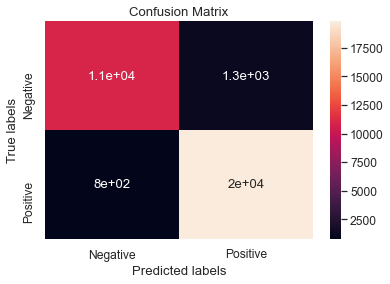

In [215]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Negative', 'Positive']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [216]:
# check the overall accuracy. 

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = sgd_clf.predict(X_test)

score =accuracy_score(y_test,y_pred)
print('accuracy is', score)

accuracy is 0.8624878522837707


**Overall accuracy is very good**

In [217]:
# F1 score for classifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred =  sgd_clf.predict(X_test)
print(f1_score(y_test,y_pred, average="macro"))

0.851170918004085


In [218]:
#score is mean accuracy

scikit_score = sgd_clf.score(X_test,y_test)
print('scikit score:', scikit_score)

scikit score: 0.8624878522837707


In [219]:
# Recall score 

recall_score(y_test, y_pred, average='macro')

0.8467232495765105

In [220]:
# Classification Report for our stochastic gradient descent algorithm

classification_report(y_test,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.84      0.78      0.81      3080\n           1       0.88      0.91      0.89      5152\n\n    accuracy                           0.86      8232\n   macro avg       0.86      0.85      0.85      8232\nweighted avg       0.86      0.86      0.86      8232\n'

In [221]:
confusion_matrix(y_test,y_pred)

array([[2415,  665],
       [ 467, 4685]], dtype=int64)

#### Test accuracy comparison of BINARY CLASS Classification Models

In [222]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Decent,0.862488
1,Logistic Regression,0.859451
6,CatBoost,0.852162
0,Support Vector Machines,0.845603
2,Random Forest,0.829446
5,XGBoost,0.821914
3,Naive Bayes,0.791667
